---
title: Fashion MNIST
categories: deep-learning
date: 2020-12-15
---


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)

## 初始化

首先引入所用的包。

然后是一些公共函数。下面代码比较长，可以先把函数的中文解释看过就好，细节忽略，后面用到再回来看。

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
import time


from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.keras import preprocessing, datasets
from tensorflow.keras import callbacks, losses, optimizers, regularizers
from tensorflow.keras import models, Model, layers
from sklearn.model_selection import train_test_split

# 设置日志
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

class ImageClassificationHelper(object):
    
    def __init__(self):
        super(ImageClassificationHelper, self).__init__()    
        self.model_results = {}
        self.data = None
            
    def set_params(self, params):
        self.params = params
        
        self.dataset_name = self.params['dataset_name']
        self.validation_percent = self.params['validation_percent']
        self.use_data_augmentation = self.params['use_data_augmentation'] 
        self.augmentation_generator = self.params['augmentation_generator']
        self.batch_size = self.params['batch_size']
        
        self.epochs = self.params['epochs']
        self.learning_rate = self.params['learning_rate']
        self.dropout = self.params['dropout']
        self.metrics = self.params['metrics']
               
        self.use_lr_schedule = self.params['use_lr_schedule']
        self.lr_schedule = self.params['lr_schedule']       
                   
        if self.lr_schedule is None: 
            self.lr_schedule = self.default_lr_schedule
         
        self.model_params = self.params['model_params']  
        
    def set_data(self, data):  
        self.data = data
        
    def set_model_results(self, model_results):  
        self.model_results = model_results          
        
    def train(self, model, epochs=None, verbose=True):    
        '''要求模型设置name属性，用于保存模型。''' 
        if epochs is None: epochs = self.epochs
        checkpoint_best_only = callbacks.ModelCheckpoint(filepath=model.checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True, 
                                                         save_best_only=True,
                                                         verbose=False)
        lr_patience = min(8, int(epochs*0.2))
        stopping_patience = min(20, int(epochs*0.3))
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), min_lr=0.5e-6, 
                                                patience=lr_patience, verbose=verbose) 
        learning_rate_scheduler = callbacks.LearningRateScheduler(self.lr_schedule)
        early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=stopping_patience)
        
        if self.use_lr_schedule:
            callbacks_ = [checkpoint_best_only, reduce_lr, early_stopping, learning_rate_scheduler] 
        else:
            callbacks_ = [checkpoint_best_only, reduce_lr, early_stopping] 

        if self.data.val_dataset is None:
            validation_dataset = self.data.test_dataset
        else:
            validation_dataset = self.data.val_dataset          

        with TaskTime('training', True) as t: 
            if self.use_data_augmentation:
                steps_per_epoch = self.data.train_dataset_aug.steps_per_epoch
                history = model.fit(self.train_dataset_aug, validation_data=validation_dataset, 
                                    epochs=epochs, verbose=verbose, steps_per_epoch=steps_per_epoch,
                                    callbacks=callbacks_)  
            else:
                history = model.fit(self.data.train_dataset, validation_data=validation_dataset, 
                                    epochs=epochs, verbose=verbose, 
                                    callbacks=callbacks_)           
            history.train_time = t.elapsed_time()
        return history  
    
    def compile(self, model):
        learning_rate = self.get_learning_rate(model)
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                      loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=self.metrics)  

        if self.use_data_augmentation:
            model.checkpoint_path = './checkpoints/{}_aug/{}/checkpoint'.format(self.dataset_name, model.name)
        else:    
            model.checkpoint_path = './checkpoints/{}/{}/checkpoint'.format(self.dataset_name, model.name) 
        return model    
                                                         
    def evaluate(self, model, train_time, train_dataset=None, val_dataset=None, test_dataset=None):
        '''评估当前模型，并且显示所有模型的信息'''
        model_results = self.model_results
        if train_dataset is None: train_dataset = self.data.train_dataset
        if val_dataset is None: val_dataset = self.data.val_dataset
        if test_dataset is None: test_dataset = self.data.test_dataset
        
        train_loss, train_accuracy = model.evaluate(train_dataset, verbose=False)
        if val_dataset is not None:
            val_loss, val_accuracy = model.evaluate(val_dataset, verbose=False)
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=False)
        if  model.name not in model_results or model_results[model.name]['test_accuracy']<test_accuracy:
            if val_dataset is not None:
                model_results[model.name] = {'train_loss':round(train_loss, 6), 
                                      'train_accuracy':round(train_accuracy, 4), 
                                      'val_loss':round(val_loss, 6), 
                                      'val_accuracy':round(val_accuracy, 4),    
                                      'test_loss':round(test_loss, 6), 
                                      'test_accuracy':round(test_accuracy, 4),                               
                                      'weight_number':self.get_weight_num(model), 
                                      'model':model,
                                      'train_time':round(train_time,0)
                                     }    
            else:
                 model_results[model.name] = {'train_loss':round(train_loss, 6), 
                                      'train_accuracy':round(train_accuracy, 4),  
                                      'test_loss':round(test_loss, 6), 
                                      'test_accuracy':round(test_accuracy, 4),                               
                                      'weight_number':self.get_weight_num(model), 
                                      'model':model,
                                      'train_time':round(train_time,0)
                                     }               
           
    def load_best_checkpoint(self, model):
        '''加载最佳的checkpoint'''
        model.load_weights(model.checkpoint_path)
        return model    

    def get_model_parameter(self, model_name, parameter_name):
        if model_name not in self.model_params: return None
        if parameter_name not in self.model_params[model_name] : return None
        return self.model_params[model_name][parameter_name]
    
    def get_learning_rate(self, model_name):
        learning_rate = self.get_model_parameter(model_name, 'learning_rate')
        if learning_rate is None: learning_rate=self.learning_rate
        return learning_rate
 
    def get_dropout(self, model_name):
        dropout = self.get_model_parameter(model_name, 'dropout')
        if dropout is None: dropout=self.dropout
        return dropout        
        
    def show_images(self, images, labels, x_num=6, y_num=6, figsize=(8,8), images_mean=None):
        '''显示图片'''
        classes = self.data.classes
        plt.figure(figsize=figsize)
        channel_count = images.shape[-1]
        for i in range(x_num*y_num):
            plt.subplot(x_num, y_num, i+1)
            if images_mean is not None:
                image = images[i]+images_mean
            else:
                image = images[i]
            if channel_count==1:
                plt.imshow(image, cmap='gray')
            else:
                plt.imshow(image)
            label = labels[i] if classes is None else classes[labels[i]]
            plt.title("{}".format(label))
            plt.xticks([])
            plt.yticks([])    

        plt.tight_layout()
        plt.subplots_adjust(wspace=0.3, hspace=0.3)      
        plt.show()  
        
    def show_model_results(self):         
        '''按照test_accuracy倒序显示所有模型的信息'''
        model_results = self.model_results
        models_remove1 = {key:{key1:value1 for key1, value1 in value.items() if key1 != 'model'} 
                          for key, value in model_results.items()}
        df_models = pd.DataFrame.from_dict(models_remove1, orient='index')
        df_models = df_models.sort_values('test_accuracy', ascending=False) 
        display(df_models)        
        
    def plot_distribution(self, train_labels=None, test_labels=None):
        '''打印类的分布'''
        if train_labels is None: train_labels = self.data.train_labels
        if test_labels is None: test_labels = self.data.test_labels
            
        classes = self.data.classes
        
        def plot_dist(labels, title, color='blue', width = 0.7):
            bin_count = np.bincount(labels)
            bin_percentage = bin_count/len(labels)
            rects = plt.bar(np.arange(len(bin_count)), bin_count, width, color=color)
            plt.title(title)
            if classes is None:
                plt.xticks(range(len(bin_count))) 
            else:
                plt.xticks(range(len(bin_count)), labels=classes, rotation = 45) 
            plt.ylim(0, max(bin_count)*1.1) 

            for i, r in enumerate(rects):
                plt.annotate('{:0.1f}%'.format(int(bin_percentage[i]*100)),
                            xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')        

        plt.figure(figsize=(16, 4))
        plt.subplot(121)
        plot_dist(train_labels, 'Train', color='teal')
        plt.subplot(122)
        plot_dist(test_labels, 'Test', color='coral')

        plt.show()    


    def plot_history(self, history):
        '''显示训练的loss和accuracy的走势图'''
        plt.figure(figsize=(16, 5))
        max_epoch = len(history.history['accuracy'])
        epochs = range(1, max_epoch+1)
        if max_epoch <= 20:
            xticks = range(0, max_epoch+1)
        else:
            xticks = range(0, max_epoch+1, (max_epoch-1)//20+1)
        plt.subplot(121)
        plt.plot(epochs, history.history['accuracy'])
        plt.plot(epochs, history.history['val_accuracy'])
        plt.title('Accuracy vs. epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.xticks(xticks)
        plt.legend(['Training', 'Validation'], loc='lower right')

        plt.subplot(122)
        plt.plot(epochs, history.history['loss'])
        plt.plot(epochs, history.history['val_loss'])
        plt.title('Loss vs. epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.xticks(xticks)
        plt.legend(['Training', 'Validation'], loc='upper right')
        plt.show()    

    def plot_confusion_matrix(self, model1, images=None, labels=None, model2=None):
        '''打印混淆矩阵'''
        def plot_cm(model):
            predictions = model.predict(images).argmax(axis=-1)               
            cm = confusion_matrix(labels, predictions)
            bin_count = np.bincount(labels)
            if classes is None: 
                index = range(len(bin_count))      
                columns = range(len(bin_count))  
            else:
                index = classes     
                columns = classes           
            df_cm = pd.DataFrame(cm, index=index, columns=columns)

            plt.title("{} - Confusion matrix".format(model.name))
            sns.heatmap(df_cm, annot=True, fmt='g',cmap='coolwarm')
            if classes is not None: 
                plt.yticks(rotation = 0)
                plt.xticks(rotation = 45)
            plt.xlabel("Predicted")
            plt.ylabel("Actual")

        if images is None: images = self.data.test_images
        if labels is None: labels = self.data.test_labels 
        classes = self.data.classes

        if model2 is not None:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plot_cm(model1)
            plt.subplot(1, 2, 2)
            plot_cm(model2)         
        else:  
            plt.figure(figsize=(8, 6))
            plot_cm(model1)

        plt.show()    

    def plot_predicted_sample(self, models, images=None, labels=None, sample_count=5, 
                              show_error=True, images_mean=None):    
        '''查看一些样本的分类情况'''
        def get_class(label):
            if classes is None:
                return label
            else:
                return classes[label]

        def plot_var(model, image, label):
            predict = np.squeeze(tf.nn.softmax(model.predict(image)).numpy())
            max_like = np.argmax(predict)
            max_like_value = predict[max_like]

            if classes is None:
                _classes = range(label_count)
                plt.text(max_like-0.5, max_like_value+0.02, 
                         '{:0.1f}%'.format(max_like_value*100), fontsize=8)            
                plt.bar(_classes, predict, width=0.9, color='steelblue', alpha=0.8) 
                plt.ylim(0, 1.2)
                plt.xticks(range(label_count), _classes, fontsize=8)          
            else:
                _classes = classes
                plt.text(max_like_value+0.02, max_like, 
                         '{:0.1f}%'.format(max_like_value*100), fontsize=8)             
                plt.barh(_classes, predict, height=0.9, color='steelblue', alpha=0.8) 
                plt.xlim(0, 1.2)
                plt.yticks(range(label_count), _classes, fontsize=8)
            plt.title('{}: {}'.format(model.name, get_class(max_like)), fontsize=10)

        if images is None: images = self.data.test_images
        if labels is None: labels = self.data.test_labels 
        classes = self.data.classes
        
        if show_error:
            base_predictions = models[0].predict(images).argmax(axis=-1)  
            error_indexes = base_predictions != labels
            error_images = images[error_indexes]
            error_labels = labels[error_indexes]
            sample_indexes = np.random.randint(len(error_images), size=sample_count)  
            sample_images = error_images[sample_indexes]
            sample_labels = error_labels[sample_indexes]
        else:
            sample_indexes = np.random.randint(len(labels), size=sample_count)  
            sample_images = images[sample_indexes]
            sample_labels = labels[sample_indexes]

        bin_count = np.bincount(labels)
        label_count = len(bin_count)
        column_count = len(models)+1 
        if classes is None:
            plt.figure(figsize=(2.2*column_count, sample_count*2.2))
        else:
            plt.figure(figsize=(2.8*column_count, sample_count*2.8))
        channel_count = images.shape[-1]
        for i in range(sample_count):
            plt.subplot(sample_count, column_count, column_count*i+1)        
            if images_mean is not None:
                image = sample_images[i]+images_mean
            else:
                image = sample_images[i]
            if channel_count==1:
                plt.imshow(image, cmap='gray')
            else:
                plt.imshow(image)        
            plt.title('actual: {}'.format(get_class(sample_labels[i])), fontsize=10)
            plt.xticks([])
            plt.yticks([])

            for j, model in enumerate(models):
                plt.subplot(sample_count, column_count, column_count*i+j+2)
                plot_var(model, sample_images[i:i+1], sample_labels[i])

        plt.subplots_adjust(wspace=0.5, hspace=0.5)         
        plt.show()    

    def plot_model_structure(self, model):    
        '''打印模型的结构'''
        img = tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 
        display(img)
    
    def get_weight_num(self, obj):
        '''得到模型或layer可训练参数的个数'''
        return np.sum([np.prod(p.shape) for p in obj.trainable_weights]) 
    
    def default_lr_schedule(self, epoch):
        """Learning Rate Schedule

        Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
        Called automatically every epoch as part of callbacks during training.

        # Arguments
            epoch (int): The number of epochs

        # Returns
            lr (float32): learning rate
        """
        lr = 1e-3
        if epoch > 180:
            lr *= 0.5e-3
        elif epoch > 160:
            lr *= 1e-3
        elif epoch > 120:
            lr *= 1e-2
        elif epoch > 80:
            lr *= 1e-1
        print('Learning rate: ', lr)
        return lr
    

class ImageDataset(object):
    def __init__(self, model_helper):
        super(ImageDataset, self).__init__() 
        
        self.dataset_name = params['dataset_name']        
        self.batch_size = params['batch_size']
        self.validation_percent = params['validation_percent']                
        self.augmentation_generator = params['augmentation_generator']
        
        if self.augmentation_generator is None: 
            self.augmentation_generator = self.get_image_data_generator() 
                
        print('load {} data from source'.format(self.dataset_name))
        self.classes = self.get_classes()
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.load_data()
        self.input_shape = self.train_images.shape[1:]
        
        print('create train, validation and test dataset')
        self.train_dataset, self.val_dataset, self.test_dataset, self.train_dataset_aug = self.get_datasets() 
        
    def get_classes(self):
        dataset_name = self.dataset_name
        if dataset_name=='mnist':
            classes = None            
        elif dataset_name=='fashion-mnist':            
            classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
                       'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        elif dataset_name=='cifar10': 
            classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        else:
            raise Exception('{} is not supported '.format(dataset_name))
        return classes

        
    def load_data(self):
        dataset_name = self.dataset_name
        if dataset_name=='mnist':
            (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
        elif dataset_name=='fashion-mnist':
            (train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()
        elif dataset_name=='cifar10':    
            (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
        else:
            raise Exception('{} is not supported '.format(dataset_name))
        if len(train_images.shape)<4:
            train_images = np.expand_dims(train_images, axis=-1) 
            test_images = np.expand_dims(test_images, axis=-1)            
            
        print('train:', train_images.shape, train_labels.shape)
        print('test:', test_images.shape, test_labels.shape)            
        return (train_images, train_labels), (test_images, test_labels)
        
    def get_datasets(self, random_state=1031):
        validation_percent = self.validation_percent
        batch_size = self.batch_size
        if validation_percent>0:
            print('split train into train and validation: ', X_train.shape, y_train.shape)
            X_train, X_val, y_train, y_val = train_test_split(self.train_images, self.train_labels, 
                                                              test_size=validation_percent, 
                                                              random_state=random_state)
            print('train:', X_train.shape, y_train.shape)
            print('validation:', X_val.shape, y_val.shape)    
        else:
            X_train, X_val, y_train, y_val = self.train_images, None, self.train_labels, None
            

        test_dataset = tf.data.Dataset.from_tensor_slices((self.test_images, self.test_labels))
        test_dataset = test_dataset.batch(batch_size)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(len(y_train), reshuffle_each_iteration = True)
        train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
        
        train_steps_per_epoch =  int(len(X_train) / batch_size)
        
        if self.augmentation_generator is not None:                      
            train_dataset_aug = self.augmentation_generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)             
            train_dataset_aug.steps_per_epoch = int(len(X_train) / batch_size)
            # compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).              
            self.augmentation_generator.fit(X_train)
        else:
            train_dataset_aug = None
   
        if validation_percent>0: 
            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            val_dataset = val_dataset.shuffle(len(y_val), reshuffle_each_iteration = True)
            val_dataset = val_dataset.batch(batch_size)
        else:
            val_dataset = None
        
        return train_dataset, val_dataset, test_dataset, train_dataset_aug  

    def get_image_data_generator(self):
        datagen = preprocessing.image.ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=15,
            # randomly shift images horizontally
            width_shift_range=0.05,
            # randomly shift images vertically
            height_shift_range=0.05,
            # randomly flip images
            horizontal_flip=False,
            # randomly flip images
            vertical_flip=False
        )    
        return datagen   
    
class TaskTime:
    '''用于显示执行时间'''

    def __init__(self, task_name, show_start=False):
        super(TaskTime, self).__init__()
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))   
        
        
def set_gpu_memory(gpu_memory_limit=None):   
    if gpu_memory_limit is None: gpu_memory_limit= self.set_gpu_memory
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    print('set max gpu memory to {}'.format(gpu_memory_limit))
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=gpu_memory_limit)]
    )        

In [2]:
set_gpu_memory(2048)
model_results={}

set max gpu memory to 2048


In [3]:
params = {
    'dataset_name': 'fashion-mnist',
    'validation_percent': 0,    
    'use_data_augmentation': False,
    'augmentation_generator': None,   
    'batch_size': 32,    
    'epochs': 100,    
    'learning_rate':0.001,
    'dropout':0.3,
    'metrics':['accuracy'], 
    'use_lr_schedule': False,
    'lr_schedule': None,
    'model_params':{
        'mlp':{'dropout':0.3}
    }
}

In [4]:
data = ImageDataset(params)

load fashion-mnist data from source
train: (60000, 28, 28, 1) (60000,)
test: (10000, 28, 28, 1) (10000,)
create train, validation and test dataset


In [5]:
helper = ImageClassificationHelper()
helper.set_params(params)
helper.set_model_results(model_results)
helper.set_data(data)

## 数据

MNIST数据集包含60,000张training图片和10,000张test图片，每张图片由$28\times28$ 个像素点构成，每个像素点用一个灰度值(0−255)表示。下面开始加载数据。

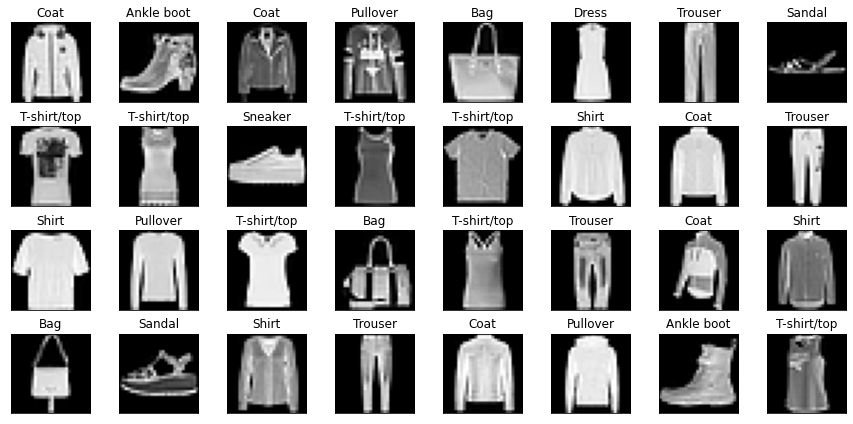

In [6]:
images, labels = iter(helper.data.train_dataset).next()
helper.show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6))

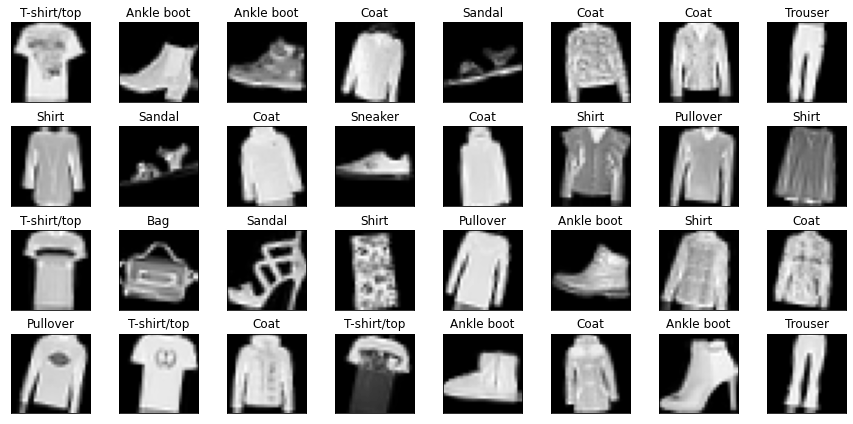

In [7]:
images, labels = helper.data.train_dataset_aug.next()
helper.show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6))

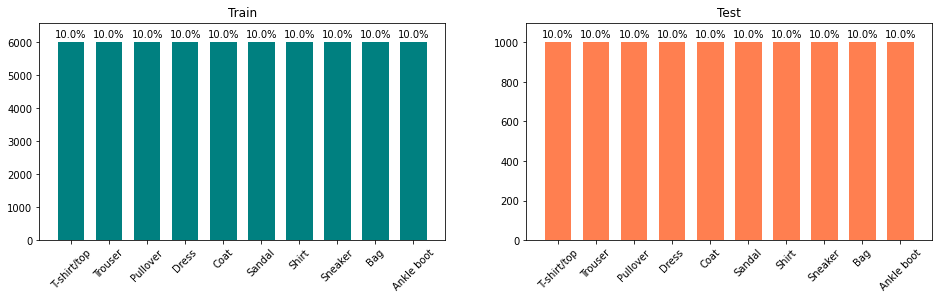

In [8]:
helper.plot_distribution()

## MLP

In [9]:
def get_mlp(helper, name='mlp', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name) 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Flatten()(input)
    x = layers.Dense(128, activation='relu')(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model

mlp_model = get_mlp(helper)
mlp_model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________




下面来训练模型。

2020-12-24 11:27:57,937: INFO: start training


Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4545 - accuracy: 0.5497 - val_loss: 0.9339 - val_accuracy: 0.6567
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0289 - accuracy: 0.6188 - val_loss: 0.8214 - val_accuracy: 0.6946
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9917 - accuracy: 0.6307 - val_loss: 0.7367 - val_accuracy: 0.7285
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9102 - accuracy: 0.6501 - val_loss: 0.7127 - val_accuracy: 0.7197
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8868 - accuracy: 0.6605 - val_loss: 0.6648 - val_accuracy: 0.7414
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.8731 - accuracy: 0.6683 - val_loss: 0.6639 - val_accuracy: 0.7418
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8543 - accuracy: 0.6748 - val_loss: 0.7796 - val_ac

1875/1875 [==============================] - 4s 2ms/step - loss: 0.6305 - accuracy: 0.7386 - val_loss: 0.6045 - val_accuracy: 0.7931
Epoch 53/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6285 - accuracy: 0.7394 - val_loss: 0.6026 - val_accuracy: 0.7916
Epoch 54/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6299 - accuracy: 0.7380 - val_loss: 0.6022 - val_accuracy: 0.7910


2020-12-24 11:31:13,710: INFO: finish training [elapsed time: 195.77 seconds]


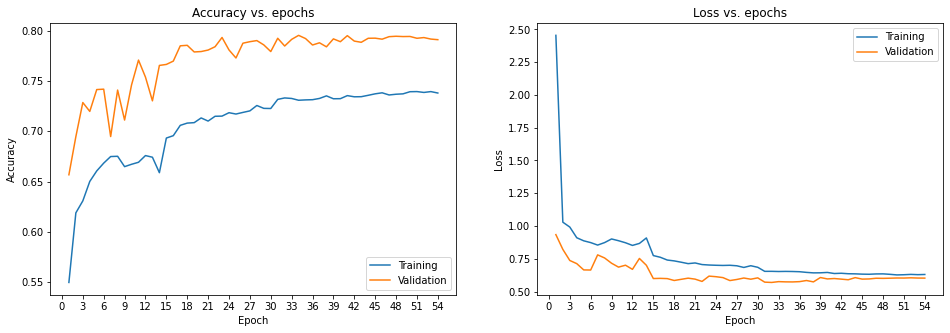

In [10]:
history = helper.train(mlp_model, epochs=helper.epochs)
helper.plot_history(history)

,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.469379,0.8149,0.573576,0.7953,101770,195.0


----------------------------------------------------------------------------------------------------


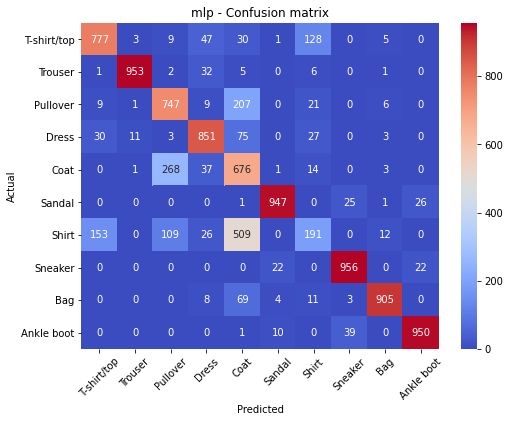

----------------------------------------------------------------------------------------------------


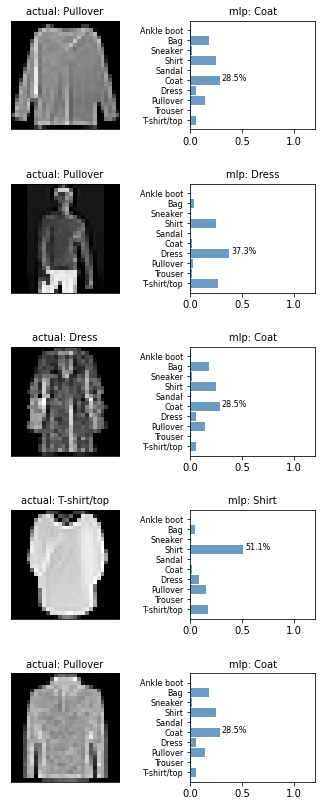

In [11]:
# 评估
mlp_model = get_mlp(helper)
mlp_model = helper.load_best_checkpoint(mlp_model)
helper.evaluate(mlp_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(mlp_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([mlp_model], sample_count=5) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

## LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [12]:
def get_lenet(helper, name='lenet', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name) 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Conv2D(6, (5, 5), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)   
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(84, activation='relu')(x)   
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)  

    return model    

# 创建模型
lenet_model = get_lenet(helper)
lenet_model.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64    



下面来训练模型。

2020-12-24 11:31:19,778: INFO: start training


Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7007 - accuracy: 0.7434 - val_loss: 0.4214 - val_accuracy: 0.8398
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4822 - accuracy: 0.8223 - val_loss: 0.3776 - val_accuracy: 0.8576
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4306 - accuracy: 0.8425 - val_loss: 0.3459 - val_accuracy: 0.8723
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4062 - accuracy: 0.8536 - val_loss: 0.3297 - val_accuracy: 0.8789
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3873 - accuracy: 0.8582 - val_loss: 0.3223 - val_accuracy: 0.8823
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3737 - accuracy: 0.8633 - val_loss: 0.3286 - val_accuracy: 0.8739
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3613 - accuracy: 0.8666 - val_loss: 0.3534 - val_ac

1875/1875 [==============================] - 6s 3ms/step - loss: 0.2594 - accuracy: 0.9032 - val_loss: 0.2352 - val_accuracy: 0.9138
Epoch 57/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2573 - accuracy: 0.9046 - val_loss: 0.2445 - val_accuracy: 0.9093
Epoch 58/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2550 - accuracy: 0.9061 - val_loss: 0.2363 - val_accuracy: 0.9124
Epoch 59/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2566 - accuracy: 0.9041 - val_loss: 0.2437 - val_accuracy: 0.9115
Epoch 60/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2528 - accuracy: 0.9067 - val_loss: 0.2332 - val_accuracy: 0.9133
Epoch 61/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2547 - accuracy: 0.9058 - val_loss: 0.2344 - val_accuracy: 0.9130
Epoch 62/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2557 - accuracy: 0.9050 - val_loss: 0.2405 - val_accuracy

2020-12-24 11:38:40,442: INFO: finish training [elapsed time: 440.66 seconds]


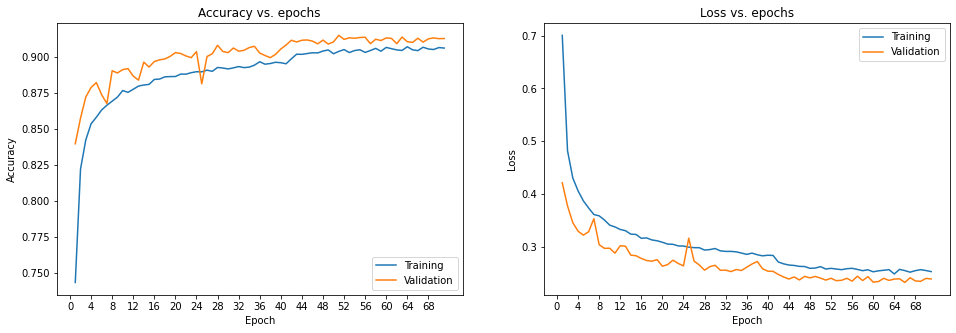

In [13]:
# 训练
history = helper.train(lenet_model, epochs=helper.epochs)
helper.plot_history(history)



下面来评估模型并和mlp模型进行对比。

,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
lenet,0.173724,0.9339,0.237122,0.9151,61750,440.0
mlp,0.469379,0.8149,0.573576,0.7953,101770,195.0


----------------------------------------------------------------------------------------------------


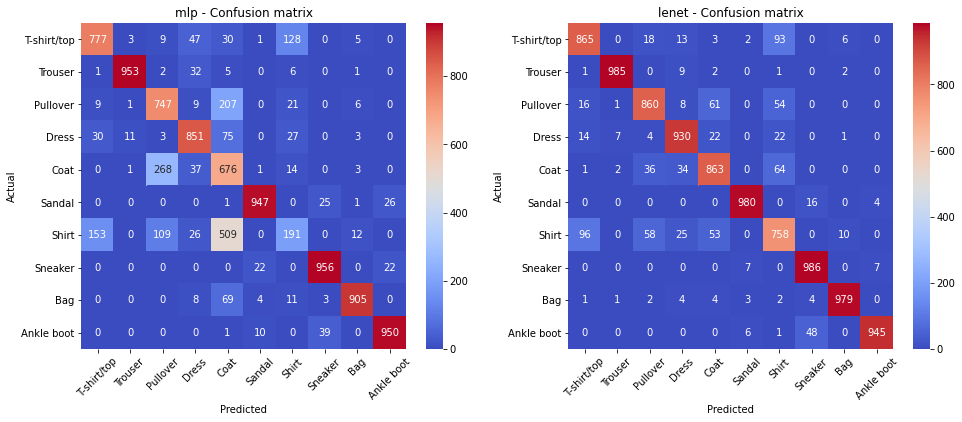

----------------------------------------------------------------------------------------------------


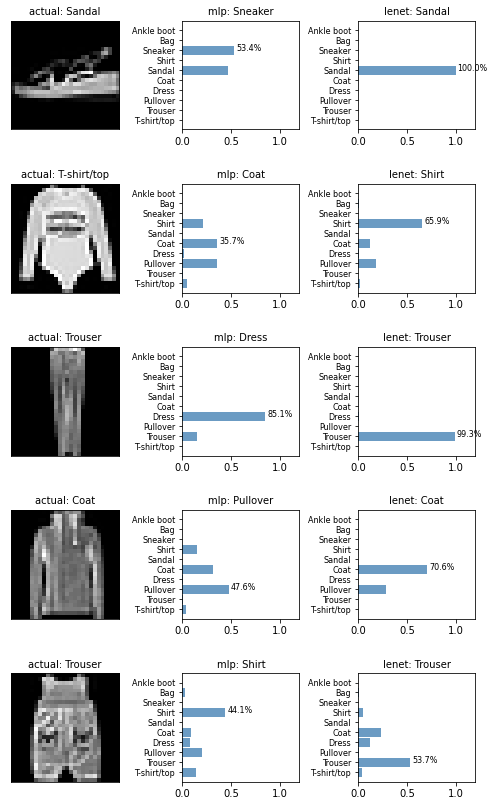

In [14]:
# 评估
lenet_model = get_lenet(helper)
lenet_model = helper.load_best_checkpoint(lenet_model)
helper.evaluate(lenet_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(mlp_model, model2=lenet_model)  

# 模型对比
print('-'*100)
helper.plot_predicted_sample([mlp_model, lenet_model], sample_count=5) 



从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

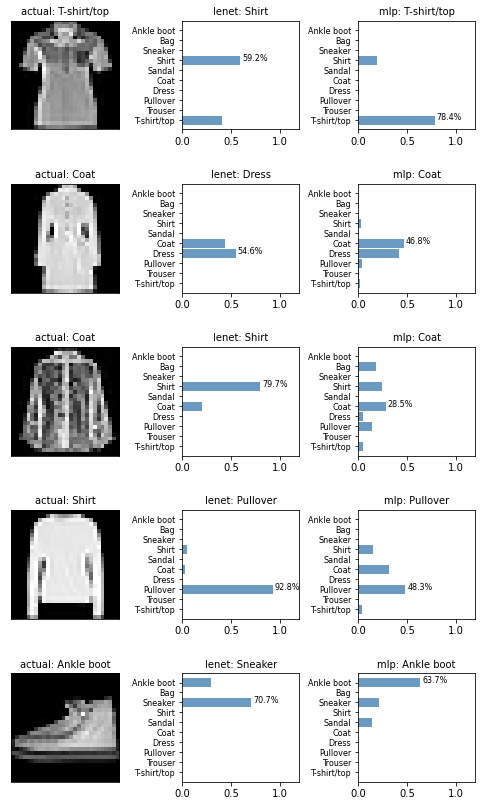

In [15]:
# 错误分析
helper.plot_predicted_sample([lenet_model, mlp_model], sample_count=5) 


上图中，可以看到对于部分数字的识别，mlp甚至要更好一点啊，还有一些数字，则是一起都错了。

## Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度。

In [16]:
def get_custom1(helper, name='custom1', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name) 
        
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) 
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model   

# 创建模型
custom1_model = get_custom1(helper)
custom1_model.summary()

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256 


可以发现参数的个数已经和mlp差不多了，下面来训练模型。

In [17]:
# 训练
history = helper.train(custom1_model, epochs=helper.epochs)
helper.plot_history(history)

2020-12-24 11:38:52,781: INFO: start training


Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6436 - accuracy: 0.7688 - val_loss: 0.3809 - val_accuracy: 0.8579
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4150 - accuracy: 0.8490 - val_loss: 0.3213 - val_accuracy: 0.8797
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3690 - accuracy: 0.8638 - val_loss: 0.2960 - val_accuracy: 0.8905
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3387 - accuracy: 0.8766 - val_loss: 0.3045 - val_accuracy: 0.8899
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3213 - accuracy: 0.8824 - val_loss: 0.2901 - val_accuracy: 0.8943
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3095 - accuracy: 0.8871 - val_loss: 0.2626 - val_accuracy: 0.9025
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2986 - accuracy: 0.8911 - val_loss: 0.2681 - val_ac

2020-12-24 11:40:24,528: INFO: finish training [elapsed time: 91.75 seconds]


KeyboardInterrupt: 



下面来评估模型并和lenet模型进行对比。

In [ ]:
# 评估
custom1_model = get_custom1(helper)
custom1_model = helper.load_best_checkpoint(custom1_model)
helper.evaluate(custom1_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(lenet_model, model2=custom1_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([lenet_model, custom1_model], sample_count=5) 



可以看到custom1模型的效果比lenet有些许提升（经过多次测试，平均好0.1-0.3个百分点）。上面最后一幅图，也能看到custom1模型学习到了不少新的模式。下面来看错误分析。

In [ ]:
# 错误分析  
helper.plot_predicted_sample([custom1_model, mlp_model, lenet_model], sample_count=5) 

## Customer 2

In [ ]:
def get_custom2(helper, name='custom2', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name)
        
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    if dropout>0: x = layers.Dropout(dropout)(x)   
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    
    return model   

# 创建模型
custom2_model = get_custom2(helper)
custom2_model.summary()

In [ ]:
# 训练
history = helper.train(custom2_model, epochs=helper.epochs)
helper.plot_history(history)

In [ ]:
# 评估
custom2_model = get_custom2(helper)
custom2_model = helper.load_best_checkpoint(custom2_model)
helper.evaluate(custom2_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(custom1_model, model2=custom2_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([custom1_model, custom2_model], sample_count=5) 

In [ ]:
# 错误分析
helper.plot_predicted_sample([custom2_model, mlp_model, lenet_model, custom1_model], sample_count=5) 

## VGG

In [ ]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, dropout=0, block_name='block'):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, name='{}_con{}'.format(block_name, i+1))(x)
        if use_bn: x = layers.BatchNormalization(name='{}_bn{}'.format(block_name, i+1))(x)
        x = layers.ReLU(name='{}_relu{}'.format(block_name, i+1))(x)
    x = layers.MaxPooling2D((2, 2), name='{}_maxpooling1'.format(block_name))(x)
    if dropout>0: x = layers.Dropout(dropout, name='{}_dropout1'.format(block_name))(x)
    return x
    
def get_vgg(helper, name='vgg',
              dense_layer_count=1, 
              dense_layer_units=128,
              conv_filters=64,
              block_count=3,
              use_bn=True,
              dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name)  
        
    input = layers.Input(shape=helper.data.input_shape)
    x = input    
    for i in range(block_count): 
        x = get_block(x, conv_filters, conv_count=2, use_bn=use_bn, dropout=dropout, 
                      block_name='block{}'.format(i+1))
        conv_filters = conv_filters*2
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model


vgg8_model = get_vgg(helper, dense_layer_count=1, block_count=3, name='vgg8')
vgg8_model.summary()



In [ ]:
# 训练
history = helper.train(vgg8_model, epochs=helper.epochs)
helper.plot_history(history)

In [ ]:
# 评估
vgg8_model = get_vgg(helper, dense_layer_count=1, block_count=3, name='vgg8')
vgg8_model = helper.load_best_checkpoint(vgg8_model)
helper.evaluate(vgg8_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(custom2_model, model2=vgg8_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([custom2_model, vgg8_model], sample_count=5) 

In [ ]:
# 错误分析
helper.plot_predicted_sample([vgg8_model, mlp_model, lenet_model, custom1_model, custom2_model], sample_count=5) 

## vgg_hpt

In [ ]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, dropout=0):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    return x
    

def get_vgg_hpt(helper, name='vgg_hpt',
              dense_layer_count=1, 
              dense_layer_units=128,
              conv_filters=64,
              block_count=3,
              use_bn=True,
              dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name)  
        
    input = layers.Input(shape=helper.data.input_shape)
    x = input    
    for i in range(block_count):        
        x = get_block(x, conv_filters, conv_count=2, use_bn=use_bn, dropout=dropout)
        conv_filters = conv_filters*2
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model


vgg_hpt_model = get_vgg_hpt(helper)
vgg_hpt_model.summary()

In [ ]:
# 训练
history = helper.train(vgg_hpt_model, epochs=helper.epochs)
helper.plot_history(history)

In [ ]:
# 评估
vgg_hpt_model = get_vgg_hpt(helper)
vgg_hpt_model = helper.load_best_checkpoint(vgg_hpt_model)
helper.evaluate(vgg_hpt_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(vgg8_model, model2=vgg_hpt_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([vgg8_model, vgg_hpt_model], sample_count=5) 


# 错误分析


In [ ]:
# 错误分析
helper.plot_predicted_sample([vgg_hpt_model, mlp_model, lenet_model, custom1_model, custom2_model, vgg8_model], 
                             sample_count=5) 

## Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10, name='resnet_v1'):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)

        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    if input_shape[0]<32:
        x = layers.AveragePooling2D(pool_size=7)(x)
    else:
        x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model

def get_resnet_v1(helper, depth=32, name='resnet_v1'):   
    model = resnet_v1(helper.data.input_shape, depth=depth, name=name)
    helper.compile(model)
    return model

resnet_v1_model = get_resnet_v1(helper, depth=20, name='resnet_v1_20')
resnet_v1_model.summary()

In [ ]:
history = helper.train(resnet_v1_model, epochs=helper.epochs)
helper.plot_history(history)

In [ ]:
# 评估
resnet_v1_model = get_resnet_v1(helper, depth=20, name='resnet_v1_20')
resnet_v1_model = helper.load_best_checkpoint(resnet_v1_model)
helper.evaluate(resnet_v1_model, train_time=history.train_time)
helper.show_model_results()

# 混淆矩阵
print('-'*100)
helper.plot_confusion_matrix(vgg_hpt_model, model2=resnet_v1_model)   

# 模型对比
print('-'*100)
helper.plot_predicted_sample([vgg_hpt_model, resnet_v1_model], sample_count=5) 

In [ ]:
# 错误分析
helper.plot_predicted_sample([resnet_v1_model, mlp_model, lenet_model, custom1_model, custom2_model, 
                              vgg8_model, vgg_hpt_model],
                             sample_count=5) 

## 总结